In [6]:
import pandas as pd
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [11]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [12]:
file_path = "/content/drive/My Drive/sales.csv"
df = pd.read_csv(file_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/sales.csv'

In [8]:
df.info()

NameError: name 'df' is not defined

In [13]:
display(df)

NameError: name 'df' is not defined

In [ ]:
# Полный сброс среды выполнения в Colab
!kill -9 -1

In [ ]:
from sklearn.metrics import classification_report

# --- Предобработка ---
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%y %H:%M:%S")
df["Sale_Year"] = df["Date"].dt.year
df["Sale_Month"] = df["Date"].dt.month

categorical_cols = ['Product Type', 'Product', 'Type', 'Market', 'Market Size', 'State']
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = ohe.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(categorical_cols))

numeric_features = df[['Profit', 'Margin', 'COGS', 'Total Expenses', 'Marketing',
                       'Inventory', 'Budget Margin', 'Budget Sales', 'Sale_Year', 'Sale_Month']]

# Целевая переменная как числа
df['Sales_Category'] = pd.qcut(df['Sales'], q=3, labels=[0, 1, 2])
target = 'Sales_Category'

# Объединяем данные
data_encoded = pd.concat([numeric_features.reset_index(drop=True),
                          encoded_df.reset_index(drop=True)], axis=1)
data_encoded[target] = df[target].reset_index(drop=True)

# Разделяем данные
X = data_encoded.drop(columns=[target])
Y = data_encoded[target]

# --- МОДЕЛЬ ДО PCA ---
X_train, X_test, y_train, y_test_m1 = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_m1 = LogisticRegression(max_iter=2000)
model_m1.fit(X_train_scaled, y_train)
y_pred_m1 = model_m1.predict(X_test_scaled)

# Метрики ДО PCA
accuracy_before_pca = accuracy_score(y_test_m1, y_pred_m1)
conf_matrix_before_pca = confusion_matrix(y_test_m1, y_pred_m1)
classification_report_before_pca = classification_report(y_test_m1, y_pred_m1)

# --- МОДЕЛЬ ПОСЛЕ PCA ---
scaler_pca = StandardScaler()
X_scaled_full = scaler_pca.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled_full)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, Y, test_size=0.2, stratify=Y, random_state=42)

model_pca = LogisticRegression(max_iter=2000)
model_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = model_pca.predict(X_test_pca)

# Метрики ПОСЛЕ PCA
accuracy_after_pca = accuracy_score(y_test_pca, y_pred_pca)
conf_matrix_after_pca = confusion_matrix(y_test_pca, y_pred_pca)
classification_report_after_pca = classification_report(y_test_pca, y_pred_pca)

# --- Вывод результатов ---
print(f"\nModel 1 (Logistic Regression) Accuracy: {accuracy_before_pca:.4f}")
print(f"Classification Report Before PCA:\n{classification_report_before_pca}")

print(f"\nModel 1 (PCA) Accuracy: {accuracy_after_pca:.4f}")
print(f"Classification Report After PCA:\n{classification_report_after_pca}")


Model 1 (Logistic Regression) Accuracy: 0.9600
Classification Report Before PCA:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       292
           1       0.94      0.93      0.94       275
           2       0.96      0.98      0.97       283

    accuracy                           0.96       850
   macro avg       0.96      0.96      0.96       850
weighted avg       0.96      0.96      0.96       850


Model 1 (PCA) Accuracy: 0.9247
Classification Report After PCA:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       292
           1       0.89      0.87      0.88       275
           2       0.95      0.97      0.96       283

    accuracy                           0.92       850
   macro avg       0.92      0.92      0.92       850
weighted avg       0.92      0.92      0.92       850



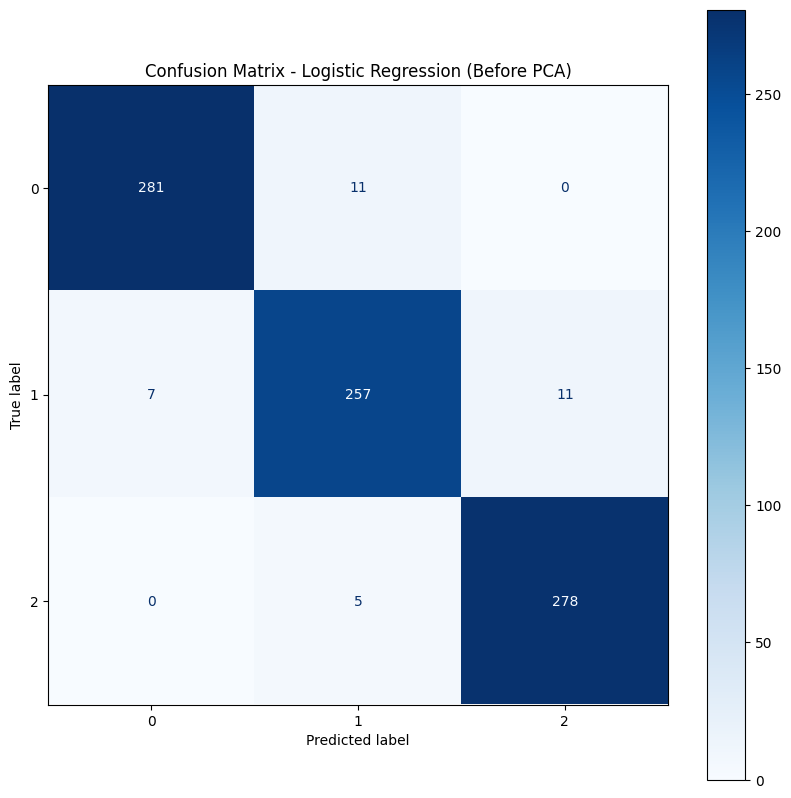

In [ ]:
# --- Отображение матрицы путаницы ДО PCA ---
plt.rcParams["figure.figsize"] = (10, 10)
disp_m1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_before_pca,
                                 display_labels=y_test_m1.unique())
disp_m1.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression (Before PCA)")
plt.show()

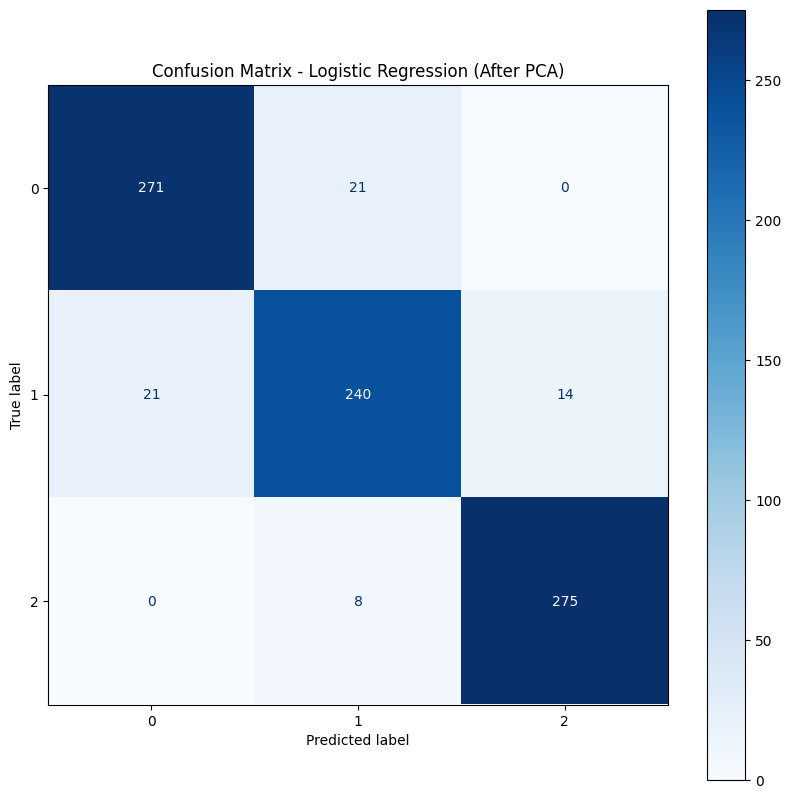

In [ ]:
# --- Отображение матрицы путаницы ПОСЛЕ PCA ---
plt.rcParams["figure.figsize"] = (10, 10)
disp_pca = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_after_pca,
                                  display_labels=y_test_pca.unique())
disp_pca.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression (After PCA)")
plt.show()

In [ ]:
# Новые признаки
df["Profit_Margin_Ratio"] = df["Profit"] / (df["COGS"] + 1)
df["Marketing_Efficiency"] = df["Profit"] / (df["Marketing"] + 1)
df["Profit_Diff"] = df["Profit"] - df["Budget Profit"]
df["COGS_Diff"] = df["COGS"] - df["Budget COGS"]
df["Margin_Diff"] = df["Margin"] - df["Budget Margin"]

# Категориальные признаки
categorical_cols = ['Product Type', 'Market', 'State']
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_cat = ohe.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_cat, columns=ohe.get_feature_names_out(categorical_cols))

# Числовые признаки
numeric_features = df[['Profit', 'COGS', 'Marketing', 'Inventory',
                       'Profit_Margin_Ratio', 'Marketing_Efficiency',
                       'Profit_Diff', 'COGS_Diff', 'Margin_Diff']]

# Целевая переменная
df['Sales_Category'] = pd.qcut(df['Sales'], q=3, labels=[0, 1, 2])
target = 'Sales_Category'

# Сбор всех данных
data = pd.concat([numeric_features.reset_index(drop=True),
                  encoded_df.reset_index(drop=True)], axis=1)
data[target] = df[target].reset_index(drop=True)

# Разделение
X = data.drop(columns=[target])
y = data[target]
X_train, X_test, y_train_m2, y_test_m2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Нормализация
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Обучение логистической регрессии
model_m2 = LogisticRegression(max_iter=2000)
model_m2.fit(X_train, y_train_m2)
y_pred_m2 = model_m2.predict(X_test)

# Метрики логистической регрессии
accuracy = accuracy_score(y_test_m2, y_pred_m2)
conf_matrix = confusion_matrix(y_test_m2, y_pred_m2)

print(f"\nModel 2 (Logistic Regression) Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# --- Модель KNN ---
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train_m2)
y_pred_knn = knn.predict(X_test)

accuracy_knn = accuracy_score(y_test_m2, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test_m2, y_pred_knn)

print(f"\nModel 2 (KNN) Accuracy: {accuracy_knn:.4f}")
print("Confusion Matrix:")
print(conf_matrix_knn)


Model 2 (Logistic Regression) Accuracy: 0.9282
Confusion Matrix:
[[264  28   0]
 [ 11 250  14]
 [  0   8 275]]

Model 2 (KNN) Accuracy: 0.9071
Confusion Matrix:
[[259  33   0]
 [ 20 241  14]
 [  0  12 271]]


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Существующие числовые признаки
df["Profit_Ratio"] = df["Profit"] / (df["Budget Sales"] + 1)
df["Expense_Ratio"] = df["Total Expenses"] / (df["Budget Sales"] + 1)
df["Inventory_Turnover"] = df["COGS"] / (df["Inventory"] + 1)
df["Marketing_Share"] = df["Marketing"] / (df["Total Expenses"] + 1)

# Новые числовые признаки
df["Profit_per_Unit"] = df["Profit"] / (df["COGS"] + 1)
df["Marketing_Efficiency_Advanced"] = df["Profit"] / (df["Marketing"] + 1)
df["Cost_Structure_Ratio"] = df["COGS"] / (df["Total Expenses"] + 1)

# Категориальные признаки
categorical_cols = ['State', 'Market', 'Market Size', 'Product Type', 'Product', 'Type']
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_cat = ohe.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_cat, columns=ohe.get_feature_names_out(categorical_cols))

# Финальные числовые признаки
numeric_features = df[[
    "Profit_Ratio", "Expense_Ratio", "Inventory_Turnover", "Marketing_Share",
    "Profit_per_Unit", "Marketing_Efficiency_Advanced", "Cost_Structure_Ratio"
]]

# Целевая переменная
df['Sales_Category'] = pd.qcut(df['Sales'], q=3, labels=[0, 1, 2])
target = 'Sales_Category'

# Объединение
data = pd.concat([numeric_features.reset_index(drop=True),
                  encoded_df.reset_index(drop=True)], axis=1)
data[target] = df[target].reset_index(drop=True)

# Разделение
X = data.drop(columns=[target])
y = data[target]
X_train, X_test, y_train, y_test_m3 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Нормализация
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Модель ДО SVM (Logistic Regression) ---
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred_m3 = model.predict(X_test)

accuracy_log = accuracy_score(y_test_m3, y_pred_m3)
conf_matrix_log = confusion_matrix(y_test_m3, y_pred_m3)

print("\nModel 3 (Logistic Regression) Accuracy:", round(accuracy_log, 4))
print("Confusion Matrix:")
print(conf_matrix_log)

# --- Модель ПОСЛЕ: Метод опорных векторов (SVM) ---
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_m3 = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test_m3, y_pred_m3)
conf_matrix_svm = confusion_matrix(y_test_m3, y_pred_m3)

print("\nModel 3 (SVM) Accuracy:", round(accuracy_svm, 4))
print("Confusion Matrix:")
print(conf_matrix_svm)


Model 3 (Logistic Regression) Accuracy: 0.7906
Confusion Matrix:
[[224  51  17]
 [ 52 190  33]
 [  6  19 258]]

Model 3 (SVM) Accuracy: 0.8588
Confusion Matrix:
[[232  60   0]
 [ 22 233  20]
 [  0  18 265]]


In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import graphviz
from sklearn import tree

numeric_features = df[['Profit', 'Margin', 'COGS', 'Total Expenses', 'Marketing', 'Budget Sales']]

df['Sales_Category'] = pd.qcut(df['Sales'], q=3, labels=[0, 1, 2])
target = 'Sales_Category'

X_tree = numeric_features
Y_tree = df[target]

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree, Y_tree, test_size=0.2, stratify=Y_tree, random_state=42
)

clf_tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)
clf_tree.fit(X_train_tree, y_train_tree)

dot_data = tree.export_graphviz(
    clf_tree,
    out_file=None,
    feature_names=X_tree.columns,
    class_names=['Low', 'Medium', 'High'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph.render("sales_decision_tree")

y_pred_tree = clf_tree.predict(X_test_tree)
accuracy_tree = accuracy_score(y_test_tree, y_pred_tree)
print(f"\nDecision Tree Accuracy: {accuracy_tree:.4f}")
print("Decision Tree Classification Report:")
print(classification_report(y_test_tree, y_pred_tree))


Decision Tree Accuracy: 0.9600
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       292
           1       0.93      0.95      0.94       275
           2       1.00      0.97      0.98       283

    accuracy                           0.96       850
   macro avg       0.96      0.96      0.96       850
weighted avg       0.96      0.96      0.96       850



In [ ]:
from google.colab import files
files.download("sales_decision_tree.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Feature Importances in Decision Tree:
Margin          0.562189
COGS            0.396557
Profit          0.021133
Budget Sales    0.012269
Marketing       0.007851
dtype: float64


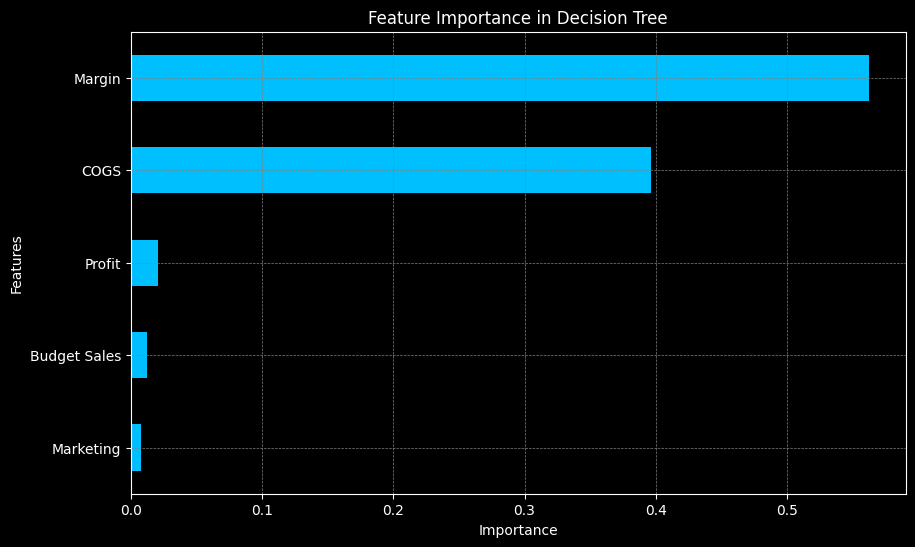

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importances = pd.Series(clf_tree.feature_importances_, index=X_tree.columns).sort_values(ascending=False)[lambda x: x > 0]

print("\nFeature Importances in Decision Tree:")
print(feature_importances)

plt.figure(figsize=(10, 6))
plt.style.use('dark_background')
feature_importances.plot(kind='barh', color='deepskyblue')
plt.title('Feature Importance in Decision Tree', color='white')
plt.xlabel('Importance', color='white')
plt.ylabel('Features', color='white')
plt.gca().invert_yaxis()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.show()